In [11]:
import os, sys
import glob
import _pickle as pkl
import numpy as np
import PIL.Image as Image
from skimage.transform import resize

In [12]:
def is_grey_scale(img_path="n04389033_19729.JPEG"):
    im = Image.open(img_path).convert('RGB')
    w,h = im.size
    for i in range(w):
        for j in range(h):
            r,g,b = im.getpixel((i,j))
            if r != g != b: return False
    return True

In [ ]:
'''
Used to resize Tanks & Elephants!
'''

### PATH need to be fixed
# Mac Paths.
data_path= "/Users/yannick/Documents/Playground/Python/data/tanks"
save_dir = "/Users/yannick/Documents/Playground/Python/data/tanks_64_64/"

if not os.path.exists(save_dir):
    os.makedirs(save_dir)

preserve_ratio = True
image_size = (64, 64)
#crop_size = (32, 32)

imgs = glob.glob(data_path+"/*.JPEG")


for i, img_path in enumerate(imgs):
    img = Image.open(img_path)
    print(i, len(imgs), img_path)

    if not is_gray_scale(img_path):
        if img.size[0] != image_size[0] or img.size[1] != image_size[1] :
            if not preserve_ratio:
                img = img.resize((image_size), Image.ANTIALIAS)
            else:
                ### Resize based on the smallest dimension
                scale = image_size[0] / float(np.min(img.size))
                new_size = (int(np.floor(scale * img.size[0]))+1, int(np.floor(scale * img.size[1])+1))
                img = img.resize((new_size), Image.ANTIALIAS)

                ### Crop the 64/64 center
                tocrop = np.array(img)
                center = (int(np.floor(tocrop.shape[0] / 2.)), int(np.floor(tocrop.shape[1] / 2.)))
                print(tocrop.shape, center, (center[0]-32,center[0]+32), (center[1]-32,center[1]+32))
                if len(tocrop.shape) == 3:
                    tocrop = tocrop[center[0]-32:center[0]+32, center[1] - 32:center[1]+32, :]
                else:
                    tocrop = tocrop[center[0]-32:center[0]+32, center[1] - 32:center[1]+32]
                img = Image.fromarray(tocrop)

        img.save(save_dir + os.path.basename(img_path))
    else:
        print("Skip! Gray Scale!")


In [31]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2

save_dir = "/Users/yannick/Documents/Playground/Python/data/tanks_64_64/"
image_size = (64, 64)

data_dir = save_dir

N = len(os.listdir(data_dir))
data = np.empty((N, image_size[0], image_size[1], 3), dtype=np.uint8)

for i, fpath in enumerate(os.listdir(data_dir)):
    #print(i, ":", fpath)
    data[i] = cv2.resize(cv2.imread(os.path.join(data_dir, fpath), cv2.IMREAD_COLOR), (image_size[0],image_size[1]), interpolation=cv2.INTER_AREA)

nb_images = len(data)
split_percent = 0.8
data_x_train = data[:int(nb_images*split_percent), ...]
data_x_test = data[int(nb_images*split_percent):nb_images, ...]

print(len(data))
print(len(data_x_train))
print(len(data_x_test))

plt.figure()
plt.axis("off")
plt.imshow(data[245])

1410
1128
282


In [18]:
'''This script demonstrates how to build a variational autoencoder
with Keras and deconvolution layers.

Reference: "Auto-Encoding Variational Bayes" https://arxiv.org/abs/1312.6114
'''
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

from keras.layers import Input, Dense, Lambda, Flatten, Reshape
from keras.layers import Conv2D, Conv2DTranspose
from keras.models import Model
from keras import backend as K
from keras import metrics
from keras.datasets import mnist

In [36]:
# input image dimensions
img_rows, img_cols, img_chns = 64, 64, 3
# number of convolutional filters to use
filters = 64
# convolution kernel size
num_conv = 3

batch_size = 100
if K.image_data_format() == 'channels_first':
    original_img_size = (img_chns, img_rows, img_cols)
else:
    original_img_size = (img_rows, img_cols, img_chns)
latent_dim = 2
intermediate_dim = 128
epsilon_std = 1.0
epochs = 50

x = Input(batch_shape=(batch_size,) + original_img_size)
conv_1 = Conv2D(img_chns,
                kernel_size=(2, 2),
                padding='same', activation='relu')(x)
conv_2 = Conv2D(filters,
                kernel_size=(2, 2),
                padding='same', activation='relu',
                strides=(2, 2))(conv_1)
conv_3 = Conv2D(filters,
                kernel_size=num_conv,
                padding='same', activation='relu',
                strides=1)(conv_2)
conv_4 = Conv2D(filters,
                kernel_size=num_conv,
                padding='same', activation='relu',
                strides=1)(conv_3)
flat = Flatten()(conv_4)
hidden = Dense(intermediate_dim, activation='relu')(flat)

z_mean = Dense(latent_dim)(hidden)
z_log_var = Dense(latent_dim)(hidden)


def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(batch_size, latent_dim),
                              mean=0., stddev=epsilon_std)
    return z_mean + K.exp(z_log_var) * epsilon

# note that "output_shape" isn't necessary with the TensorFlow backend
# so you could write `Lambda(sampling)([z_mean, z_log_var])`
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

# we instantiate these layers separately so as to reuse them later
decoder_hid = Dense(intermediate_dim, activation='relu')
decoder_upsample = Dense(filters * 32 * 32, activation='relu')

if K.image_data_format() == 'channels_first':
    output_shape = (batch_size, filters, 32, 32)
else:
    output_shape = (batch_size, 32, 32, filters)

decoder_reshape = Reshape(output_shape[1:])
decoder_deconv_1 = Conv2DTranspose(filters,
                                   kernel_size=num_conv,
                                   padding='same',
                                   strides=1,
                                   activation='relu')
decoder_deconv_2 = Conv2DTranspose(filters, num_conv,
                                   padding='same',
                                   strides=1,
                                   activation='relu')
if K.image_data_format() == 'channels_first':
    output_shape = (batch_size, filters, 65, 65)
else:
    output_shape = (batch_size, 65, 65, filters)
decoder_deconv_3_upsamp = Conv2DTranspose(filters,
                                          kernel_size=(3, 3),
                                          strides=(2, 2),
                                          padding='valid',
                                          activation='relu')
decoder_mean_squash = Conv2D(img_chns,
                             kernel_size=2,
                             padding='valid',
                             activation='sigmoid')

hid_decoded = decoder_hid(z)
up_decoded = decoder_upsample(hid_decoded)
reshape_decoded = decoder_reshape(up_decoded)
deconv_1_decoded = decoder_deconv_1(reshape_decoded)
deconv_2_decoded = decoder_deconv_2(deconv_1_decoded)
x_decoded_relu = decoder_deconv_3_upsamp(deconv_2_decoded)
x_decoded_mean_squash = decoder_mean_squash(x_decoded_relu)


def vae_loss(x, x_decoded_mean):
    # NOTE: binary_crossentropy expects a batch_size by dim
    # for x and x_decoded_mean, so we MUST flatten these!
    x = K.flatten(x)
    x_decoded_mean = K.flatten(x_decoded_mean)
    xent_loss = img_rows * img_cols * metrics.binary_crossentropy(x, x_decoded_mean)
    kl_loss = - 0.5 * K.mean(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return xent_loss + kl_loss

vae = Model(x, x_decoded_mean_squash)
vae.compile(optimizer='rmsprop', loss=vae_loss)
vae.summary()

# train the VAE on MNIST digits
#(x_train, _), (x_test, y_test) = mnist.load_data()
x_train = data_x_train
x_test = data_x_test

x_train = x_train.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), 64,64,3))
x_train = x_train[:int(len(x_train)/100)*100, ...]
x_test = x_test.astype('float32') / 255.
x_test = x_test.reshape((len(x_test), 64,64,3))
x_test = x_test[:int(len(x_test)/100)*100, ...]

print('x_train.shape:', x_train.shape)
print('x_test.shape:', x_test.shape)
print('batch_size: ', batch_size)

vae.fit(x_train, x_train,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test, x_test))

# build a model to project inputs on the latent space
encoder = Model(x, z_mean)

# display a 2D plot of the digit classes in the latent space
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
#plt.figure(figsize=(6, 6))
#plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1])
#plt.colorbar()
#plt.show()

# build a digit generator that can sample from the learned distribution
decoder_input = Input(shape=(latent_dim,))
_hid_decoded = decoder_hid(decoder_input)
_up_decoded = decoder_upsample(_hid_decoded)
_reshape_decoded = decoder_reshape(_up_decoded)
_deconv_1_decoded = decoder_deconv_1(_reshape_decoded)
_deconv_2_decoded = decoder_deconv_2(_deconv_1_decoded)
_x_decoded_relu = decoder_deconv_3_upsamp(_deconv_2_decoded)
_x_decoded_mean_squash = decoder_mean_squash(_x_decoded_relu)
generator = Model(decoder_input, _x_decoded_mean_squash)

# display a 2D manifold of the digits
#n = 15  # figure with 15x15 digits
#digit_size = 28
#figure = np.zeros((digit_size * n, digit_size * n))
# linearly spaced coordinates on the unit square were transformed through the inverse CDF (ppf) of the Gaussian
# to produce values of the latent variables z, since the prior of the latent space is Gaussian
#grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
#grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

#for i, yi in enumerate(grid_x):
#    for j, xi in enumerate(grid_y):
#        z_sample = np.array([[xi, yi]])
#        z_sample = np.tile(z_sample, batch_size).reshape(batch_size, 2)
#        x_decoded = generator.predict(z_sample, batch_size=batch_size)
#        digit = x_decoded[0].reshape(digit_size, digit_size)
#        figure[i * digit_size: (i + 1) * digit_size,
#               j * digit_size: (j + 1) * digit_size] = digit

#plt.figure(figsize=(10, 10))
#plt.imshow(figure, cmap='Greys_r')
#plt.show()


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_10 (InputLayer)            (100, 64, 64, 3)      0                                            
____________________________________________________________________________________________________
conv2d_41 (Conv2D)               (100, 64, 64, 3)      39                                           
____________________________________________________________________________________________________
conv2d_42 (Conv2D)               (100, 32, 32, 64)     832                                          
____________________________________________________________________________________________________
conv2d_43 (Conv2D)               (100, 32, 32, 64)     36928                                        
___________________________________________________________________________________________

TypeError: You must first set_array for mappable

In [51]:
plt.figure(figsize=(5,5))

n = 5
grid_x = norm.ppf(np.linspace(0.05,0.95,n))
grid_y = norm.ppf(np.linspace(0.05,0.95,n))

fi, axes1 = plt.subplots(n, n, figsize=(5,5))
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = x_test_encoded[i*j,...].reshape(1,2)
        print(z_sample)
        x_decoded = generator.predict(z_sample)
        print(x_decoded)
        img_0 = x_decoded.reshape(64,64,3)
        axes1[i][j].set_axis_off()
        axes1[i][j].imshow(img_0)

[[ 1.678038   2.7379725]]
[[[[ 0.6181578   0.62988794  0.61329955]
   [ 0.67438167  0.66236418  0.64442706]
   [ 0.69432038  0.6909914   0.6731078 ]
   ..., 
   [ 0.66718423  0.67658913  0.65513062]
   [ 0.6411562   0.6636458   0.63986868]
   [ 0.59667969  0.6056205   0.59630716]]

  [[ 0.65714413  0.61941421  0.62994164]
   [ 0.67643058  0.66900259  0.67037624]
   [ 0.72429097  0.71516073  0.70097899]
   ..., 
   [ 0.68970782  0.68804252  0.69462168]
   [ 0.63185894  0.67750227  0.68364149]
   [ 0.61328399  0.60890841  0.6286208 ]]

  [[ 0.64683717  0.65448517  0.64989167]
   [ 0.7088325   0.69730335  0.68234897]
   [ 0.71422338  0.72471726  0.70012522]
   ..., 
   [ 0.69568139  0.69273591  0.68954992]
   [ 0.66335142  0.67361444  0.66455895]
   [ 0.6036275   0.62829095  0.63209164]]

  ..., 
  [[ 0.49210101  0.50270373  0.53241104]
   [ 0.50559086  0.536129    0.54677725]
   [ 0.52000868  0.53605562  0.55096745]
   ..., 
   [ 0.52883565  0.55522293  0.56548071]
   [ 0.51069087  0.536

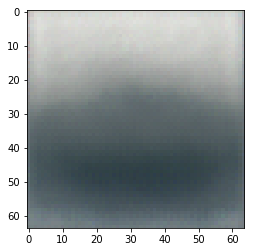

In [53]:
z_sample = x_test_encoded[1,...].reshape(1,2)
x_decoded = generator.predict(z_sample)
img_0 = x_decoded.reshape(64,64,3)

plt.figure()
plt.imshow(img_0)
plt.show()

In [43]:
x_test_encoded.shape
z_sample = x_test_encoded[i*j+i,...]
print(z_sample)

[ 1.678038   2.7379725]


In [35]:
x_train = data_x_train
x_test = data_x_test

x_train = x_train.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), 64,64,3))
print(x_train.shape)

x_train = x_train[:int(len(x_train)/100)*100, ...]
print(x_train.shape)

(1128, 64, 64, 3)
(1100, 64, 64, 3)


In [44]:
# build a digit generator that can sample from the learned distribution
decoder_input = Input(shape=(latent_dim,))
_hid_decoded = decoder_hid(decoder_input)
_up_decoded = decoder_upsample(_hid_decoded)
_reshape_decoded = decoder_reshape(_up_decoded)
_deconv_1_decoded = decoder_deconv_1(_reshape_decoded)
_deconv_2_decoded = decoder_deconv_2(_deconv_1_decoded)
_x_decoded_relu = decoder_deconv_3_upsamp(_deconv_2_decoded)
_x_decoded_mean_squash = decoder_mean_squash(_x_decoded_relu)
generator = Model(decoder_input, _x_decoded_mean_squash)